In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%load_ext watermark
%watermark -a 'Marcos Santana' -d -p numpy,pandas,rdkit,fastai,torch -v


Author: Marcos Santana

Python implementation: CPython
Python version       : 3.8.8
IPython version      : 7.22.0

numpy : 1.20.1
pandas: 1.2.4
rdkit : 2021.03.5
fastai: 2.5.2
torch : 1.9.0



In [2]:
import pandas as pd
import numpy as np
from utils.Fingerprinter import Fingerprinter
from fastai.tabular.all import *

# Load data

In [3]:
data = pd.read_csv('../data/FXA_CHEMBL.csv')
data.head()

,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,...,Target Name,Target Organism,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties
0,CHEMBL351435,NaN,0,461.95,0,3.73,16,O=C1CN(S(=O)(=O)c2cc3ccc(Cl)cc3s2)CCN1Cc1cc2cnccc2o1,Ki,'=',...,Coagulation factor X,Homo sapiens,SINGLE PROTEIN,CHEMBL1144944,1,Scientific Literature,J. Med. Chem.,2003,None,NaN
1,CHEMBL295802,NaN,0,493.01,0,2.14,18,O=C(CN1CCN(S(=O)(=O)c2cc3ccc(Cl)cc3s2)CC1=O)NCCc1ccncc1,Ki,'=',...,Coagulation factor X,Homo sapiens,SINGLE PROTEIN,CHEMBL1133063,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2000,None,NaN
2,CHEMBL62509,NaN,0,382.44,0,4.32,15m,C[C@H]1CC[C@@H](Oc2cccc(-c3nc4cc(C(=N)N)c(F)cc4[nH]3)c2O)CC1,Ki,'=',...,Coagulation factor X,Homo sapiens,SINGLE PROTEIN,CHEMBL1135195,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2002,None,NaN
3,CHEMBL416912,NaN,0,499.55,0,1.27,NC4,COc1cccc(S(=O)(=O)Nc2cccn(CC(=O)NCc3ccc(C(=N)N)cc3OC)c2=O)c1,Ki,'=',...,Coagulation factor X,Homo sapiens,SINGLE PROTEIN,CHEMBL1136066,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2002,None,NaN
4,CHEMBL140349,NaN,0,514.57,1,2.86,24b,Cc1cc(C(=O)Nc2ccc(-c3ccccc3S(N)(=O)=O)cc2)n(-c2ccc3nc(N)nc(N)c3c2)n1,Ki,'=',...,Coagulation factor X,Homo sapiens,SINGLE PROTEIN,CHEMBL1145122,1,Scientific Literature,J. Med. Chem.,2003,None,NaN


In [4]:
data['class_label'] = data['pChEMBL Value'].apply(lambda x : 1 if (x>=6.5) else 0)

# Featurize

In [5]:
feat_generator = Fingerprinter(smiles=data['Smiles'])
X = feat_generator.generate_fingerprint('ecfp',nbits=1024,radius=2)
y = data.class_label

In [11]:
feature_name = [f'fp{i}' for i in range(1024)]

In [9]:
data = pd.concat([data, pd.DataFrame(X, columns=feature_name)],axis=1)

In [10]:
data.head(2)

,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,...,fp1014,fp1015,fp1016,fp1017,fp1018,fp1019,fp1020,fp1021,fp1022,fp1023
0,CHEMBL351435,NaN,0,461.95,0,3.73,16,O=C1CN(S(=O)(=O)c2cc3ccc(Cl)cc3s2)CCN1Cc1cc2cnccc2o1,Ki,'=',...,0,0,0,0,0,0,0,0,0,0
1,CHEMBL295802,NaN,0,493.01,0,2.14,18,O=C(CN1CCN(S(=O)(=O)c2cc3ccc(Cl)cc3s2)CC1=O)NCCc1ccncc1,Ki,'=',...,0,0,0,0,0,0,0,0,0,0


# Create DataLoader

**PandasDataset**

In [12]:
procs = []
splits = RandomSplitter(0.2)(data)
splits

((#3271) [413,266,2551,591,3805,2327,2206,1728,3300,2511...],
 (#817) [733,2935,2281,589,800,2859,3550,2785,372,2291...])

In [14]:
dset = TabularPandas(df=data,cont_names=feature_name, 
                     y_names='class_label',y_block=CategoryBlock(),
                    splits=splits)

In [16]:
dls = dset.dataloaders(bs=32)

In [17]:
dls.show_batch()

# Multilayer perceptron

In [41]:
class MLP(nn.Module):
    '''Basic multi layer perceptron for bioactivity prediction
    
    Attributes:
    
    n_input : int
        Input matrix size
        
    n_hid : int
        Number of hidden units
        
    n_out : int
        Number of output units
    
    
    '''
    
    def __init__(self, n_input, n_hid, n_out):
        super().__init__()
        self.lin1 = nn.Linear(n_input, n_hid)
        self.lin2 = nn.Linear(n_hid, n_hid)
        self.output = nn.Linear(n_hid, n_out)
        
    def forward(self, cat_features,cont_features):
        res = self.lin2(self.lin1(cont_features))
        out = self.output(res)
        return out
        

In [42]:
model = MLP(n_input = X.shape[1], n_hid=100, n_out=2)

In [47]:
metrics = [Recall(pos_label=0),Recall(pos_label=1),Precision(),MatthewsCorrCoef()]

In [48]:
learn = Learner(dls, model=model,metrics=metrics)

## Train model

**Learning rate finder**

SuggestedLRs(valley=0.0005248074885457754)

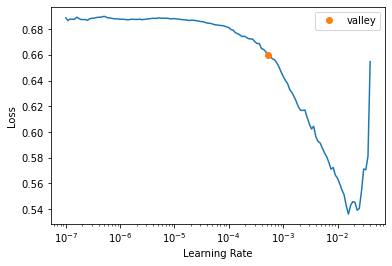

In [44]:
learn.lr_find(num_it=200)

**Training using optimal learning rate**

In [49]:
learn.fit(n_epoch=10,lr=2e-3)

epoch,train_loss,valid_loss,recall_score,recall_score,precision_score,matthews_corrcoef,time
0,0.215231,0.357318,0.789644,0.923228,0.878277,0.726539,00:01
1,0.197456,0.405862,0.792880,0.907480,0.878095,0.708699,00:01
2,0.204733,0.405341,0.692557,0.952756,0.835924,0.688737,00:01
3,0.191310,0.451219,0.818770,0.874016,0.888000,0.689439,00:01
4,0.185211,0.418178,0.773463,0.903543,0.867675,0.687194,00:01
5,0.188937,0.455782,0.831715,0.852362,0.892784,0.675424,00:01
6,0.164138,0.512806,0.734628,0.925197,0.851449,0.683514,00:01
7,0.179914,0.471809,0.744337,0.899606,0.852612,0.657390,00:01
8,0.180395,0.416217,0.783172,0.909449,0.873346,0.703044,00:01
9,0.165139,0.478053,0.802589,0.911417,0.883588,0.721961,00:01
